In [1]:
import topos
import topos.bp as bp
import fp

import torch
import matplotlib.pyplot as plt

plt.set_cmap('viridis')
#plt.style.use('dark_background')
imgdir = '/home/oli/math/maxEnt/Figures'


<Figure size 640x480 with 0 Axes>

In [2]:
from topos.bp import IsingNetwork as Ising
N = Ising.lattice(2, 3)

In [3]:
""" Singular elements """

def singular_belief(N, field=1): 
    log_third = float(torch.log(torch.ones(1) / 3))
    p_sg = N.lift_interaction([field, -log_third])
    return p_sg 

def singular_flux(N, p_sg):
    vec = N.node_eigvecs(p_sg).data[:2] 
    phi = vec.repeat(len(N.grades[1]))
    return N[1].field(phi)

B0, B1 = 0, 1
beta = torch.linspace(-.9, .9, 101)
gamma = torch.linspace(-.9, .9, 101)

# Parallelogram of consistent beliefs 
p0, p1 = (singular_belief(N, Bi) for Bi in (B0, B1))
phi  = singular_flux(N, p0)

sum = N.from_scalars(0) @ N.to_scalars(0) 
U = N._ln(p0)
#--- temperature axis ---
Xp = (p0 * U - sum(p0 * U)).data
Xp = Xp / Xp.norm()
#--- orthogornal axis --- 
Yp = (p1 - p0).data
Yp = Yp - (Xp.t() @ Yp) * Xp
Yp = Yp / Yp.norm()

V = N[0].field(Yp / p0.data)

Cons = N[0].field(p0.data + beta[:,None, None] * Xp
                          + gamma[None, :, None] * Yp)


/home/oli/fp/fp/instances/tens.py:260: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  data = torch.sparse.mm(f.data, g.data)


In [9]:
def GramSchmidt(p, xs):
    ys = p.data.sqrt() * xs
    Q, R = torch.linalg.qr(ys.T)
    q = Q.T / p.data.sqrt()
    r = R.T
    return q, r

# Logarithmic potentials 
Fix = N._ln(Cons)
fix = N.mu(Fix).data
u, v, w = N.mu(U).data, N.mu(V).data, 10 * N.codiff(phi).data

q, r = GramSchmidt(p0, torch.stack([w, u, v]))
c, a, b = q


x, y, z = ((p0.data * ui * fix).sum([-1]) for ui in (a, b, c))

[]

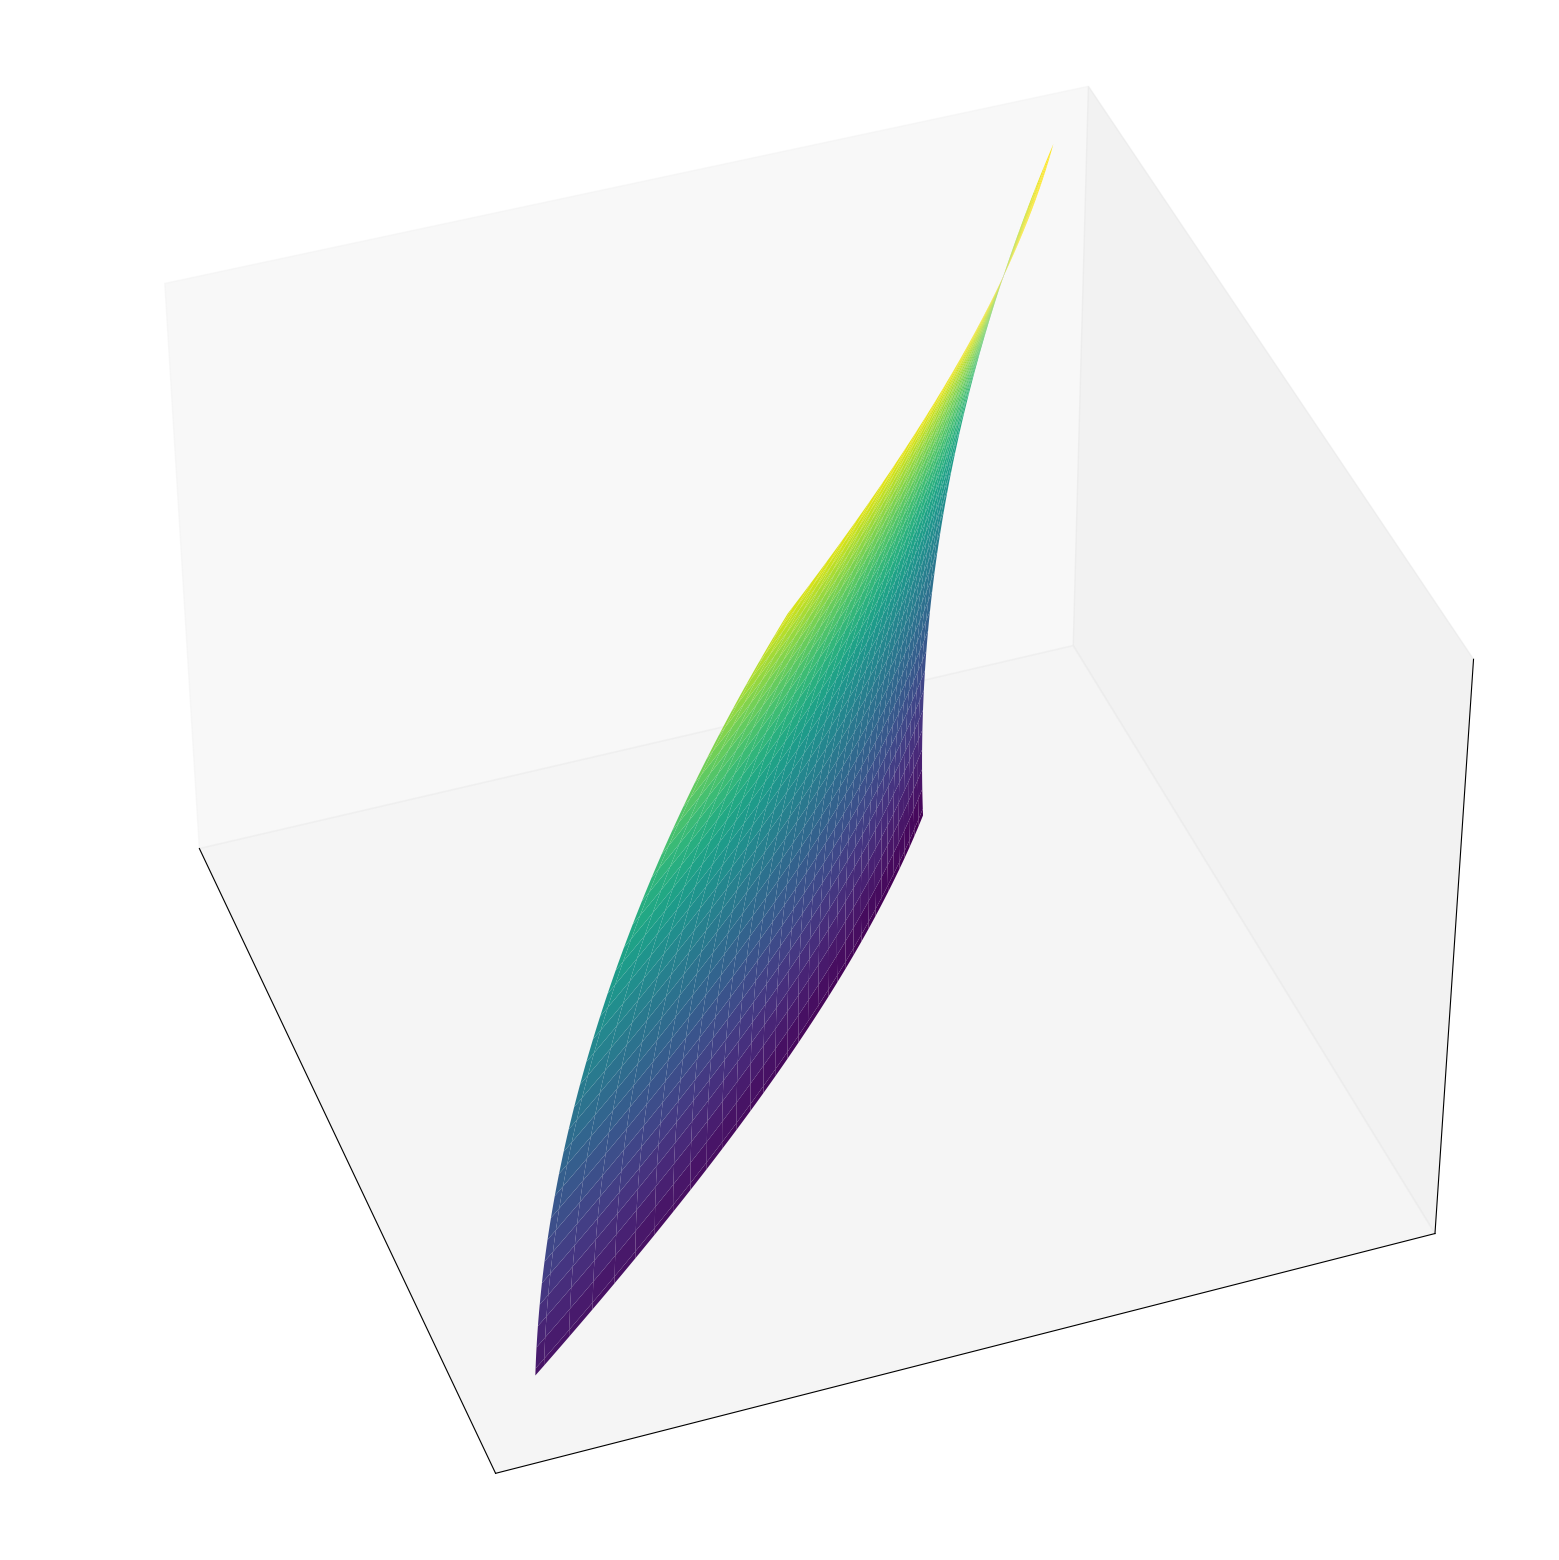

In [5]:
x, y, z = ((p0.data * ui * fix).sum([-1]) for ui in (a, b, c))

fig, ax = plt.subplots(subplot_kw = {"projection":"3d"}, figsize=(30, 20))
ax.plot_surface(x, y, z, cmap='viridis')
ax.view_init(40, 160)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


In [6]:

def radial_conservative(field=1, beta=None, gamma=None):
    """ Span of (U, V) with V = codiff(phi) """
    if beta is None:  beta  = torch.linspace(.4, 1.6, 101)
    if gamma is None: gamma = .5 * torch.linspace(-2, 1.3, 101)
    #--- singular beliefs
    log_third = float(torch.log(torch.ones(1) / 3))
    p_sg = N.lift_interaction([field, -log_third])
    #--- singular flux
    vec = N.node_eigvecs(p_sg).data[:2] 
    phi = vec.repeat(len(N.grades[1]))
    phi = N[1].field(phi)
    #--- coordinate plane
    U_sg = N._ln(p_sg)
    V_sg = N.zeta(N.codiff(phi))
    U = beta[:,None] * U_sg.data
    V = gamma[:,None] * V_sg.data
    return N[0].field(U + V[:,None,:])

torch.Size([4, 501, 501])


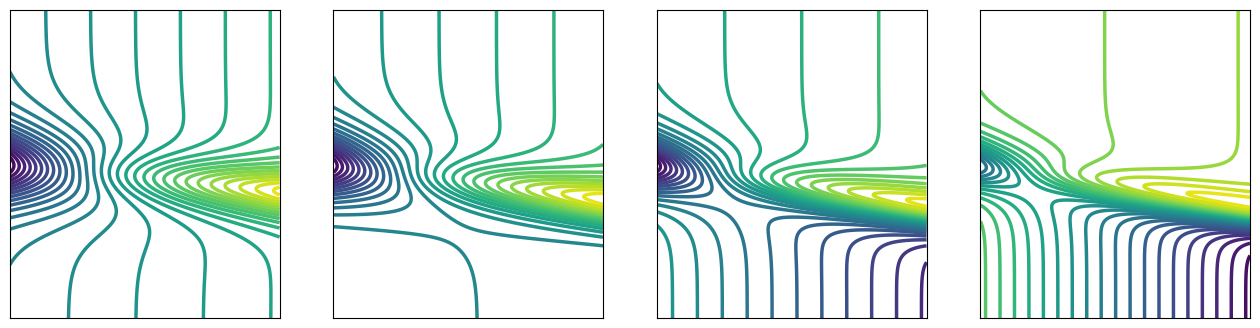

In [7]:
""" Free energy landscape accross singularity """
from topos.io import plot_contours

field_UV = [.4, .6, .8, 1.]
beta = torch.linspace(.1, 3, 501)
gamma = torch.linspace(-1.5, 1.5, 501)
UV = [radial_conservative(fi, beta, gamma) for fi in field_UV]
UV = N[0].Field().batch(UV)

F_UV = N.freeBethe(1.)(UV).data
fig = plot_contours(F_UV, levels=30, lw=2.5, size=(16, 4))

#fig.savefig(f'{imgdir}/ising_contours_2.svg')

[]

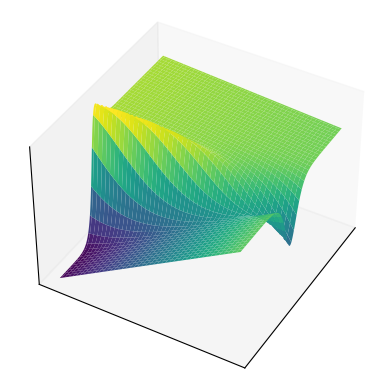

In [8]:
fig, ax = plt.subplots(subplot_kw = {"projection":"3d"})
ax.plot_surface(beta[:,None], gamma[None,:], F_UV[-1], cmap='viridis')
ax.view_init(40, 210)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
